In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from keras.optimizers import adam_v2
from sklearn.model_selection import train_test_split
import keras_metrics
from keras import metrics
from keras import backend as K
from keras.regularizers import l2
import keras
from sklearn.model_selection import KFold
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [35]:
df_train = pd.read_csv('train_preprocessed-nonPCA.csv',index_col=[0])
df_test = pd.read_csv('test_preprocessed-nonPCA.csv',index_col=[0])

In [36]:
X_train=df_train.iloc[:,:-1].values
y_train=df_train.iloc[:,-1].values
X_test=df_test.iloc[:,:-1].values
y_test=df_test.iloc[:,-1].values

# print the shape of the split dataset
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(40736, 118)
(40736,)
(10184, 118)
(10184,)


In [37]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.9

In [39]:
X_train = X_train.reshape(X_train.shape[0],118,1)
X_test = X_test.reshape(X_test.shape[0],118,1)

y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)

In [40]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                     input_shape=(X_train.shape[1], 1),
                     kernel_regularizer=l2(0.01))) # 添加L2正则化
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',
                     kernel_regularizer=l2(0.01))) # 添加L2正则化
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
history = model.fit(X_train, y_train, epochs=50, verbose=1,batch_size=10, validation_data=(X_test, y_test),callbacks=[early_stopping],shuffle = True)

Epoch 1/50
4074/4074 [==============================] - 35s 8ms/step - loss: 1.2507 - accuracy: 0.4558 - val_loss: 1.1936 - val_accuracy: 0.4733
Epoch 2/50
4074/4074 [==============================] - 32s 8ms/step - loss: 1.1925 - accuracy: 0.4812 - val_loss: 1.1895 - val_accuracy: 0.4735
Epoch 3/50
4074/4074 [==============================] - 25s 6ms/step - loss: 1.1799 - accuracy: 0.4847 - val_loss: 1.1743 - val_accuracy: 0.4811
Epoch 4/50
4074/4074 [==============================] - 15s 4ms/step - loss: 1.1708 - accuracy: 0.4913 - val_loss: 1.1706 - val_accuracy: 0.4827
Epoch 5/50
4074/4074 [==============================] - 16s 4ms/step - loss: 1.1628 - accuracy: 0.4917 - val_loss: 1.1766 - val_accuracy: 0.4802
Epoch 6/50
4074/4074 [==============================] - 15s 4ms/step - loss: 1.1586 - accuracy: 0.4966 - val_loss: 1.1772 - val_accuracy: 0.4799
Epoch 7/50
4074/4074 [==============================] - 16s 4ms/step - loss: 1.1563 - accuracy: 0.4958 - val_loss: 1.1774 - val_ac

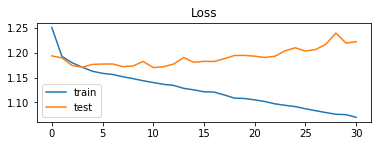

In [41]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

In [42]:
y_pred = model.predict(X_test)
y_pred.shape

319/319 [==============================] - 1s 3ms/step


(10184, 4)

In [44]:
# 如果y_test是one-hot编码的，将其转换为整数标签
if len(y_test.shape) == 2 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# 如果y_pred是概率，取概率最大的索引作为预测类别
if len(y_pred.shape) == 2 and y_pred.shape[1] > 1:
    y_pred = np.argmax(y_pred, axis=1)

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

def evaluate(y_pred, y_test):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

In [45]:
# non-co
evaluate(y_pred, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.72      0.59      3400
           1       0.29      0.07      0.11      2028
           2       0.44      0.53      0.48      3162
           3       0.54      0.37      0.44      1594

    accuracy                           0.47     10184
   macro avg       0.44      0.42      0.40     10184
weighted avg       0.45      0.47      0.44     10184



In [46]:
# non-co
from sklearn.preprocessing import label_binarize
y_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
y_pred_proba = model.predict(X_test)
from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
print(f"Multi-class AUROC (One-vs-Rest): {auroc}")

319/319 [==============================] - 1s 3ms/step
Multi-class AUROC (One-vs-Rest): 0.7046218196144606


In [33]:
# 80
evaluate(y_pred, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.71      0.60      3400
           1       0.27      0.01      0.02      2028
           2       0.44      0.59      0.50      3162
           3       0.53      0.40      0.46      1594

    accuracy                           0.49     10184
   macro avg       0.44      0.43      0.40     10184
weighted avg       0.45      0.49      0.43     10184



In [34]:
# 80
from sklearn.preprocessing import label_binarize
y_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
y_pred_proba = model.predict(X_test)
from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
print(f"Multi-class AUROC (One-vs-Rest): {auroc}")

319/319 [==============================] - 1s 4ms/step
Multi-class AUROC (One-vs-Rest): 0.7128555903854668


In [23]:
# 50
evaluate(y_pred, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.62      0.58      3400
           1       0.31      0.06      0.10      2028
           2       0.42      0.59      0.49      3162
           3       0.49      0.42      0.45      1594

    accuracy                           0.47     10184
   macro avg       0.44      0.43      0.41     10184
weighted avg       0.45      0.47      0.44     10184



In [24]:
# 50
from sklearn.preprocessing import label_binarize
y_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
y_pred_proba = model.predict(X_test)
from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
print(f"Multi-class AUROC (One-vs-Rest): {auroc}")

319/319 [==============================] - 1s 2ms/step
Multi-class AUROC (One-vs-Rest): 0.7041443437046682


In [11]:
# 100
evaluate(y_pred, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.71      0.60      3400
           1       0.30      0.04      0.07      2028
           2       0.43      0.56      0.49      3162
           3       0.51      0.39      0.44      1594

    accuracy                           0.48     10184
   macro avg       0.44      0.42      0.40     10184
weighted avg       0.45      0.48      0.44     10184



In [13]:
# 100
from sklearn.preprocessing import label_binarize
y_bin = label_binarize(y_test, classes=[0, 1, 2, 3])
y_pred_proba = model.predict(X_test)
from sklearn.metrics import roc_auc_score
auroc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr", average="macro")
print(f"Multi-class AUROC (One-vs-Rest): {auroc}")

319/319 [==============================] - 1s 3ms/step
Multi-class AUROC (One-vs-Rest): 0.7058737199530687


In [7]:
X_train = X_train.reshape(X_train.shape[0],119,1)
X_test = X_test.reshape(X_test.shape[0],119,1)

y_train = to_categorical(y_train, 4)
y_test = to_categorical(y_test, 4)
kfold = KFold(n_splits=5, shuffle=True)
fold_no = 1
models = []
scores = []

for train, test in kfold.split(X_train, y_train):
    # 创建模型
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu',
                     input_shape=(X_train.shape[1], 1),
                     kernel_regularizer=l2(0.01))) # 添加L2正则化
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu',
                     kernel_regularizer=l2(0.01))) # 添加L2正则化
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_regularizer=l2(0.01))) # 添加L2正则化
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.01))) # 添加L2正则化
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='softmax'))

    # 编译模型
    optimizer = Adam(learning_rate=0.001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=2)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # 训练模型
    print(f'Training for fold {fold_no} ...')
    history = model.fit(X_train[train], y_train[train],
                        epochs=50,
                        verbose=1,
                        batch_size=10,
                        callbacks=[early_stopping],
                        validation_data=(X_train[test], y_train[test]))

    # 评估模型
    models.append(model)
    scores.append(model.evaluate(X_train[test], y_train[test], verbose=0))
    fold_no += 1

# 打印每个折叠的准确率以及平均准确率
for i in range(len(scores)):
    print(f'Fold {i+1} - Loss: {scores[i][0]} - Accuracy: {scores[i][1]}')
print(f'Average scores for all folds - Loss: {np.mean([s[0] for s in scores])} - Accuracy: {np.mean([s[1] for s in scores])}')

Training for fold 1 ...
Epoch 1/50
3259/3259 [==============================] - 23s 6ms/step - loss: 1.3780 - accuracy: 0.4142 - val_loss: 1.2844 - val_accuracy: 0.4340
Epoch 2/50
3259/3259 [==============================] - 19s 6ms/step - loss: 1.2900 - accuracy: 0.4357 - val_loss: 1.2772 - val_accuracy: 0.4368
Epoch 3/50
3259/3259 [==============================] - 19s 6ms/step - loss: 1.2823 - accuracy: 0.4379 - val_loss: 1.2687 - val_accuracy: 0.4417
Epoch 4/50
3259/3259 [==============================] - 19s 6ms/step - loss: 1.2790 - accuracy: 0.4423 - val_loss: 1.2758 - val_accuracy: 0.4381
Epoch 5/50
3259/3259 [==============================] - 19s 6ms/step - loss: 1.2775 - accuracy: 0.4406 - val_loss: 1.2627 - val_accuracy: 0.4455
Epoch 6/50
3259/3259 [==============================] - 19s 6ms/step - loss: 1.2756 - accuracy: 0.4428 - val_loss: 1.2652 - val_accuracy: 0.4455
Epoch 7/50
3259/3259 [==============================] - 19s 6ms/step - loss: 1.2742 - accuracy: 0.4420 - v

Epoch 7/50
3259/3259 [==============================] - 19s 6ms/step - loss: 1.2765 - accuracy: 0.4443 - val_loss: 1.2657 - val_accuracy: 0.4524
Epoch 8/50
3259/3259 [==============================] - 19s 6ms/step - loss: 1.2743 - accuracy: 0.4498 - val_loss: 1.2550 - val_accuracy: 0.4581
Epoch 9/50
3259/3259 [==============================] - 19s 6ms/step - loss: 1.2719 - accuracy: 0.4476 - val_loss: 1.2604 - val_accuracy: 0.4570
Epoch 10/50
3259/3259 [==============================] - 20s 6ms/step - loss: 1.2721 - accuracy: 0.4486 - val_loss: 1.2510 - val_accuracy: 0.4548
Epoch 11/50
3259/3259 [==============================] - 25s 8ms/step - loss: 1.2707 - accuracy: 0.4485 - val_loss: 1.2520 - val_accuracy: 0.4605
Epoch 12/50
3259/3259 [==============================] - 25s 8ms/step - loss: 1.2683 - accuracy: 0.4516 - val_loss: 1.2528 - val_accuracy: 0.4571
Epoch 13/50
3259/3259 [==============================] - 24s 7ms/step - loss: 1.2673 - accuracy: 0.4509 - val_loss: 1.2485 - va

Epoch 13/50
3259/3259 [==============================] - 17s 5ms/step - loss: 1.2672 - accuracy: 0.4521 - val_loss: 1.2512 - val_accuracy: 0.4604
Epoch 14/50
3259/3259 [==============================] - 18s 6ms/step - loss: 1.2669 - accuracy: 0.4550 - val_loss: 1.2539 - val_accuracy: 0.4572
Epoch 15/50
3259/3259 [==============================] - 20s 6ms/step - loss: 1.2641 - accuracy: 0.4557 - val_loss: 1.2672 - val_accuracy: 0.4464
Epoch 16/50
3259/3259 [==============================] - 17s 5ms/step - loss: 1.2623 - accuracy: 0.4546 - val_loss: 1.2486 - val_accuracy: 0.4664
Epoch 17/50
3259/3259 [==============================] - 17s 5ms/step - loss: 1.2611 - accuracy: 0.4568 - val_loss: 1.2480 - val_accuracy: 0.4680
Epoch 18/50
3259/3259 [==============================] - 19s 6ms/step - loss: 1.2626 - accuracy: 0.4583 - val_loss: 1.2533 - val_accuracy: 0.4619
Epoch 19/50
3259/3259 [==============================] - 17s 5ms/step - loss: 1.2613 - accuracy: 0.4542 - val_loss: 1.2455 -

3259/3259 [==============================] - 16s 5ms/step - loss: 1.2602 - accuracy: 0.4594 - val_loss: 1.2440 - val_accuracy: 0.4616
Epoch 20/50
3259/3259 [==============================] - 17s 5ms/step - loss: 1.2603 - accuracy: 0.4588 - val_loss: 1.2359 - val_accuracy: 0.4702
Epoch 21/50
3259/3259 [==============================] - 17s 5ms/step - loss: 1.2590 - accuracy: 0.4590 - val_loss: 1.2382 - val_accuracy: 0.4664
Epoch 22/50
3259/3259 [==============================] - 17s 5ms/step - loss: 1.2579 - accuracy: 0.4599 - val_loss: 1.2690 - val_accuracy: 0.4468
Epoch 23/50
3259/3259 [==============================] - 17s 5ms/step - loss: 1.2578 - accuracy: 0.4569 - val_loss: 1.2447 - val_accuracy: 0.4715
Epoch 24/50
3259/3259 [==============================] - 17s 5ms/step - loss: 1.2578 - accuracy: 0.4590 - val_loss: 1.2443 - val_accuracy: 0.4664
Epoch 25/50
3259/3259 [==============================] - 17s 5ms/step - loss: 1.2592 - accuracy: 0.4541 - val_loss: 1.2354 - val_accurac

Epoch 25/50
3259/3259 [==============================] - 32s 10ms/step - loss: 1.2618 - accuracy: 0.4531 - val_loss: 1.2521 - val_accuracy: 0.4673
Epoch 26/50
3259/3259 [==============================] - 29s 9ms/step - loss: 1.2591 - accuracy: 0.4533 - val_loss: 1.2559 - val_accuracy: 0.4588
Epoch 27/50
3259/3259 [==============================] - 29s 9ms/step - loss: 1.2606 - accuracy: 0.4556 - val_loss: 1.2560 - val_accuracy: 0.4569
Epoch 28/50
3259/3259 [==============================] - 29s 9ms/step - loss: 1.2597 - accuracy: 0.4543 - val_loss: 1.2460 - val_accuracy: 0.4691
Epoch 29/50
3259/3259 [==============================] - 36s 11ms/step - loss: 1.2602 - accuracy: 0.4551 - val_loss: 1.2654 - val_accuracy: 0.4534
Epoch 30/50
3259/3259 [==============================] - 34s 11ms/step - loss: 1.2600 - accuracy: 0.4575 - val_loss: 1.2551 - val_accuracy: 0.4635
Epoch 31/50
3259/3259 [==============================] - 35s 11ms/step - loss: 1.2586 - accuracy: 0.4561 - val_loss: 1.25

In [8]:
best_fold = np.argmax([score[1] for score in scores])
best_model = models[best_fold]
y_pred = best_model.predict(X_test)


319/319 [==============================] - 2s 4ms/step


In [9]:
# 如果y_test是one-hot编码的，将其转换为整数标签
if len(y_test.shape) == 2 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)

# 如果y_pred是概率，取概率最大的索引作为预测类别
if len(y_pred.shape) == 2 and y_pred.shape[1] > 1:
    y_pred = np.argmax(y_pred, axis=1)

In [12]:
evaluate(y_pred, y_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.56      0.57      3400
           1       0.00      0.00      0.00      2028
           2       0.40      0.66      0.50      3162
           3       0.45      0.47      0.46      1594

    accuracy                           0.47     10184
   macro avg       0.36      0.42      0.38     10184
weighted avg       0.39      0.47      0.42     10184



D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
